In [67]:
import pandas as pd
import numpy as np
import os

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import shap # Ling > !pip3 install shap works. conda or pip install shap does not work. 

# plot packages for w2v-part
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style("darkgrid")

# Load saved data

In [2]:
from os.path import dirname

path = dirname(os.getcwd())
path

'c:\\Users\\EQDIYCI\\OneDrive - Allianz\\TRAININGS\\DATASCIENCE_ACADEMY\\PROJECT'

In [3]:
data_en = pd.read_pickle(path + "\data\processed\data_en3.pickle")

In [4]:
data_en.head()

marketplace  customer_id       review_id  product_id  product_parent   
0          US     12039526   RTIS3L2M1F5SM  B001CXYMFS       737716809  \
1          US      9636577   R1ZV7R40OLHKD  B00M920ND6       569686175   
2          US      2331478  R3BH071QLH8QMC  B0029CSOD2        98937668   
3          US     52495923  R127K9NTSXA2YH  B00GOOSV98        23143350   
4          US     14533949  R32ZWUXDJPW27Q  B00Y074JOM       821342511   

                                       product_title product_category   
0         Thrustmaster T-Flight Hotas X Flight Stick      Video Games  \
1  Tonsee 6 buttons Wireless Optical Silent Gamin...      Video Games   
2  Hidden Mysteries: Titanic Secrets of the Fatef...      Video Games   
3  GelTabz Performance Thumb Grips - PlayStation ...      Video Games   
4  Zero Suit Samus amiibo - Japan Import (Super S...      Video Games   

   star_rating  helpful_votes  total_votes vine verified_purchase   
0            5              0            0    N                 Y  \
1            5              0            0    N                 Y   
2            1              0            1    N                 Y   
3            3              0            0    N                 Y   
4            4              0            0    N                 Y   

                                     review_headline   
0  an amazing joystick. I especially love that yo...  \
1  Definitely a silent mouse... Not a single clic...   
2                                           One Star   
3                          good, but could be bettee   
4                                  Great but flawed.   

                                         review_body review_date language   
0  Used this for Elite Dangerous on my mac, an am...  2015-08-31       EN  \
1  Loved it,  I didn't even realise it was a gami...  2015-08-31       EN   
2     poor quality work and not as it is advertised.  2015-08-31       EN   
3  nice, but tend to slip away from stick in inte...  2015-08-31       EN   
4  Great amiibo, great for collecting. Quality ma...  2015-08-31       EN   

                                   processed_reviews   
0  use elit danger mac amaz joystick especi love ...  \
1  love even realis game mous type silent mous se...   
2                              poor qualiti advertis   
3  nice tend slip away stick intens hard press ga...   
4  great amiibo great collect qualiti materi desi...   

                                     lem_pos_ner_rem   
0  use_VERB this_PRON for_ADP on_ADP my_PRON mac_...  \
1  love_VERB it_PRON I_PRON do_AUX not_PART even_...   
2  poor_ADJ quality_NOUN work_NOUN and_CCONJ not_...   
3  nice_ADJ but_CCONJ tend_VERB to_PART slip_VERB...   
4  great_ADJ amiibo_NOUN great_ADJ for_ADP collec...   

                                head_lem_pos_ner_rem  
0  an_DET amazing_ADJ joystick_NOUN I_PRON especi...  
1  definitely_ADV a_DET silent_ADJ mouse_NOUN not...  
2                                          star_NOUN  
3    good_ADJ but_CCONJ could_AUX be_AUX bettee_VERB  
4                     great_ADJ but_CCONJ flawed_ADJ

# Undersampling to reduce calculation load and balance data

In [5]:
# need to convert column type to string, otherwise there is float in title --> cannot combine two columns head and review body
data_en['review_headline'] = data_en['review_headline'].astype(str)

In [6]:
data_en["lem_comb"] =  data_en[["lem_pos_ner_rem", "head_lem_pos_ner_rem"]].apply(lambda x: x["head_lem_pos_ner_rem"] + " " + x["lem_pos_ner_rem"] , axis=1)
data_en["head_body"] = data_en[["review_headline", "processed_reviews"]].apply(lambda x: x["review_headline"] + " " + x["processed_reviews"] , axis=1)

In [114]:
data_en[['lem_comb', 'head_body']]

NameError: name 'index' is not defined

In [7]:
# using combined headline and reviewbody for training
X = data_en[["lem_pos_ner_rem","head_lem_pos_ner_rem","lem_comb"][2]]  
X_wo_pos = data_en['head_body']
y = data_en["star_rating"]

In [100]:
print(X.shape)
print(X_wo_pos.shape)

(1753198,)
(1753198,)


In [91]:
X.head()

0    an_DET amazing_ADJ joystick_NOUN I_PRON especi...
1    definitely_ADV a_DET silent_ADJ mouse_NOUN not...
2    star_NOUN poor_ADJ quality_NOUN work_NOUN and_...
3    good_ADJ but_CCONJ could_AUX be_AUX bettee_VER...
4    great_ADJ but_CCONJ flawed_ADJ great_ADJ amiib...
Name: lem_comb, dtype: object

In [92]:
X_wo_pos.head()

0    an amazing joystick. I especially love that yo...
1    Definitely a silent mouse... Not a single clic...
2                       One Star poor qualiti advertis
3    good, but could be bettee nice tend slip away ...
4    Great but flawed. great amiibo great collect q...
Name: head_body, dtype: object

In [117]:
print(X_wo_pos[1553186:1553187])
print(X[1553186:1553187])

1580193    VERY FRAGILE! alright psp cool game look nice ...
Name: head_body, dtype: object
1580193    very_ADJ alright_INTJ so_ADV the_DET be_AUX co...
Name: lem_comb, dtype: object


In [99]:
y.head()

0    5
1    5
2    1
3    3
4    4
Name: star_rating, dtype: int64

In [105]:
# undersample the data
rs = [resample(X[y == sr], y[y == sr], X_wo_pos[y == sr], replace=False, 
    n_samples=int(np.floor(1*(X_wo_pos[y == 2].shape[0]))), random_state=123) for sr in [1,2,3,4,5]]

In [107]:
rs

[[1553186     I_PRON purchase_VERB this_DET remote_ADJ cont...
  1334110    ditto_NOUN Game_PROPN will_AUX not_PART work_V...
  1099148    lesson_NOUN learn_VERB we_PRON be_AUX not_PART...
  941421     RIP_PROPN OFF_PROPN so_ADV excited_ADJ about_A...
  1138139    do_AUX not_PART work_VERB with_ADP original_AD...
                                   ...                        
  1163205    terrible_ADJ absolutely_ADV disappointing_ADJ ...
  1660210    wow_INTJ a_DET junk_NOUN system_NOUN with_ADP ...
  637163     really_ADV what_PRON the_DET hell_NOUN have_AU...
  921066     junk_NOUN not_PART even_ADV worth_ADJ I_PRON s...
  1306955    piece_NOUN of_ADP junk_NOUN this_PRON be_AUX a...
  Name: lem_comb, Length: 93921, dtype: object,
  1553186    1
  1334110    1
  1099148    1
  941421     1
  1138139    1
            ..
  1163205    1
  1660210    1
  637163     1
  921066     1
  1306955    1
  Name: star_rating, Length: 93921, dtype: int64,
  1553186    Sony Playstation 2 Remote purch

In [94]:
X_list = [rs[r][0] for r in range(5)]
y_list = [rs[r][1] for r in range(5)]
X_wo_pos_list = [rs[r][2] for r in range(5)]

X_us = np.hstack(X_list)
y_us = np.hstack(y_list)
X_wo_pos_us = np.hstack(X_wo_pos_list)

In [102]:
# undersample the data
rs_wo_pos = [resample(X_wo_pos[y == sr], y[y == sr], replace=False, 
    n_samples=int(np.floor(1*(X_wo_pos[y == 2].shape[0]))), random_state=123) for sr in [1,2,3,4,5]]

In [104]:
X_wo_pos_list = [rs_wo_pos[r][0] for r in range(5)]
y_wo_pos_list = [rs_wo_pos[r][1] for r in range(5)]

X_wo_pos_us = np.hstack(X_wo_pos_list)
y_wo_pos_us = np.hstack(y_wo_pos_list)

print(X_wo_pos_us[0])
print(y_wo_pos_us[0])

Sony Playstation 2 Remote purchas remot control make watch dvd easier problem get consist right box press button hard get hope would get better got wors back use game control threw remot control away br br would never recommend
1


In [95]:
X_us.shape

(469605,)

In [96]:
X_us[0]

" I_PRON purchase_VERB this_DET remote_ADJ control_NOUN to_PART make_VERB watch_VERB DVD_PROPN 's_PART on_ADP the_DET easier_ADV I_PRON have_VERB problem_NOUN get_VERB it_PRON to_PART work_VERB consistantly_ADV right_ADV out_ADP of_ADP the_DET box_NOUN I_PRON have_VERB to_PART press_VERB most_ADJ of_ADP the_DET button_NOUN very_ADV hard_ADV to_PART get_VERB they_PRON to_PART work_VERB I_PRON hope_VERB it_PRON would_AUX get_VERB well_ADJ but_CCONJ it_PRON only_ADV get_VERB bad_ADJ I_PRON be_AUX now_ADV back_ADV to_ADP use_VERB the_DET game_NOUN controler_NOUN and_CCONJ throw_VERB the_DET remote_ADJ control_NOUN away_ADV br_X br_X would_AUX never_ADV recommend_VERB this_DET product_NOUN"

In [97]:
X_wo_pos_us.shape

(469605,)

In [98]:
X_wo_pos_us[0]

'Sony Playstation 2 Remote purchas remot control make watch dvd easier problem get consist right box press button hard get hope would get better got wors back use game control threw remot control away br br would never recommend'

In [ ]:
# the sampling is not working properly!!! 

# Function definitions

In [ ]:
#from sklearn.base import BaseEstimator, TransformerMixin

class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return y.todense()-1

    def transform(self, y, *args, **kwargs):
        return y.todense()-1

In [ ]:
def assess_on_val(clf, X_val_vectorized, y_val):
    print("Start predicting")
    predicted = clf.predict(X_val_vectorized)
    print("Finished predicting")
    total_accuracy = metrics.accuracy_score(predicted, y_val)

    accuracy_by_rating_class = {rc : metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc]) for rc in np.unique(y_val)}
    accuracy_by_rating_class = pd.DataFrame.from_dict(accuracy_by_rating_class, orient="index")

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(131)
    accuracy_by_rating_class.sort_index().plot(kind = "bar", ax = ax)
    ax.set_title("Accuracy per  \nrating class")
    ax.axhline(y = total_accuracy, color ='r', linestyle = '--')
    ax.get_legend().remove()
    ax.set_ylim(0,1)

    ax2 = fig.add_subplot(132)
    pd.DataFrame({"star_rating": predicted}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax2)
    ax2.set_title("Percentage of \n predicted rating class")
    ax2.get_legend().remove()
    ax2.set_ylim(0,1)

    ax3 = fig.add_subplot(133)
    pd.DataFrame({"star_rating": y_val}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax3)
    ax3.set_title("Percentage of actual \n rating classes in val")
    ax3.get_legend().remove()
    ax3.set_ylim(0,1)    
    fig.suptitle(str(clf._final_estimator), y=1.1)
    
    print("Global accuracy: " + str(total_accuracy))
    return fig


# Split data into train, test and val

In [14]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_us, y_us, test_size= 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, random_state=42)

# Illustrate class imbalance

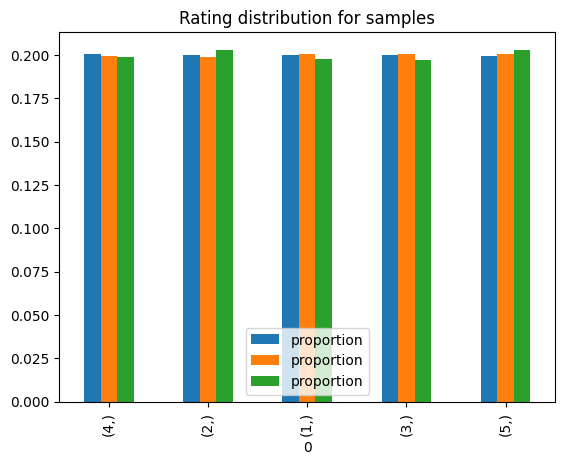

In [15]:
pd.concat([pd.DataFrame(x).value_counts(normalize=1) for x in [y_train, y_val, y_test]], axis=1).rename({0:"train", 1:"val", 2:"test"}, axis=1).plot(kind="bar")
plt.title("Rating distribution for samples");


# Pipeline: logistic regression and xbg


In [14]:
#help(LabelEncoder)

In [56]:
def selpc_fun(X,y):
        f = X.mean(axis=0)
        f = np.asarray(f).ravel()
        return f

def selpc_fun_inv(X,y):
        f = -1.0*X.mean(axis=0)
        f = np.asarray(f).ravel()
        return f

# Parameters
lr_params = dict(C=0.5, max_iter=1000)#, multi_class = "multinomial")
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.0001, max_df=0.35-0.25)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
varth_params = dict(threshold=0.00005/100)
percth_params = dict(score_func= selpc_fun, percentile = 95)

# Supervised Pipeline
# pipeline for xgb
clf_xgb = xgb.XGBClassifier(
                base_score=0.2, booster='gbtree', colsample_bylevel=0.8,
                colsample_bynode=1, colsample_bytree=0.9, eval_metric='mlogloss',
                gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.05,
                max_delta_step=0, max_depth=25, min_child_weight=1,# missing=nan,
                monotone_constraints='()', n_estimators=25, n_jobs=12,
                num_parallel_tree=1, objective='multi:softprob', random_state=0,
                reg_alpha=0.3, reg_lambda=1, scale_pos_weight=None, subsample=1,
                tree_method='exact', #use_label_encoder=True,
                validate_parameters=1, verbosity=None
        )

xgb_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("le", ModifiedLabelEncoder()),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", clf_xgb)]

# pipeline for logistic regression 
lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

## logistic regression

In [28]:
pipeline = Pipeline(lr_steps)
pipeline.fit(X_train, y_train)
print("Training_Score: ", pipeline.score(X_train, y_train), " / Val. Score: ", pipeline.score(X_val, y_val))
# Training_Score:  0.7013411980991117  / Val. Score:  0.5735975752585516

Training_Score:  0.7013411980991117  / Val. Score:  0.5735975752585516


## XGB 

In [ ]:
# pipeline = Pipeline(xgb_steps)
# pipeline.fit(X_train, y_train-1)
# print("Training_Score: ", pipeline.score(X_train, y_train-1), " / Val. Score: ", pipeline.score(X_val, y_val-1))

In [29]:
#LR Result: Training_Score:  0.6106515049882348  / Val. Score:  0.5436077256691818
#XGB: Training_Score:  0.7842903433027048  / Val. Score:  0.4886109553452914

#LR 0.25*sample Training_Score:  0.6574957410562181  / Val. Score:  0.5226007950028393
#XGB 0.7581061896649631  / Val. Score:  0.43878478137421917
#Weaker parameters: 0.40954003407155026  / Val. Score:  0.38225440090857465

#Training_Score:  0.5758446905167518  / Val. Score:  0.49630891538898353

# Tuned df_min and df_max, as well of ngram number

# 250K obs, headline and body: Training_Score:  0.7014157288217403  / Val. Score:  0.5736543607725669
# same only body: Training_Score:  0.6837767911329734  / Val. Score:  0.5496553829118191
# same only head: Training_Score:  0.49153721389962485  / Val. Score:  0.45453964693606663
# as above, all, C = 0.95: Training_Score:  0.7480222740388198  / Val. Score:  0.5698568295227887
# C =0.15: Training_Score:  0.63208086228497  / Val. Score:  0.5675783107729219
# C = 0.05: Training_Score:  0.5883668189222857  / Val. Score:  0.5544324642783626b

## Interpretation

In [ ]:
def model_interpretation:
    print(classification_report(y_val, pipeline.predict(X_val)))

    confusion_matrix = pd.crosstab(y_val, pipeline.predict(X_val), rownames=['Actual class'], colnames=['Predicted class'], normalize=1)
    confusion_matrix

### Logistic regression

#### confusion matrix

In [32]:
print(classification_report(y_val, pipeline.predict(X_val)))
#               precision    recall  f1-score   support

#            1       0.66      0.71      0.68     28261
#            2       0.50      0.48      0.49     27996
#            3       0.50      0.46      0.48     28279
#            4       0.52      0.48      0.50     28102
#            5       0.66      0.73      0.69     28243

#     accuracy                           0.57    140881
#    macro avg       0.57      0.57      0.57    140881
# weighted avg       0.57      0.57      0.57    140881

              precision    recall  f1-score   support

           1       0.66      0.71      0.68     28261
           2       0.50      0.48      0.49     27996
           3       0.50      0.46      0.48     28279
           4       0.52      0.48      0.50     28102
           5       0.66      0.73      0.69     28243

    accuracy                           0.57    140881
   macro avg       0.57      0.57      0.57    140881
weighted avg       0.57      0.57      0.57    140881



Start predicting
Finished predicting
Global accuracy: 0.5735975752585516


Predicted class      1      2      3      4      5
Actual class                                      
1                20067   6085   1218    373    518
2                 6856  13487   5830   1138    685
3                 2208   6020  13076   5172   1803
4                  733   1174   5049  13621   7525
5                  536    390    973   5786  20558

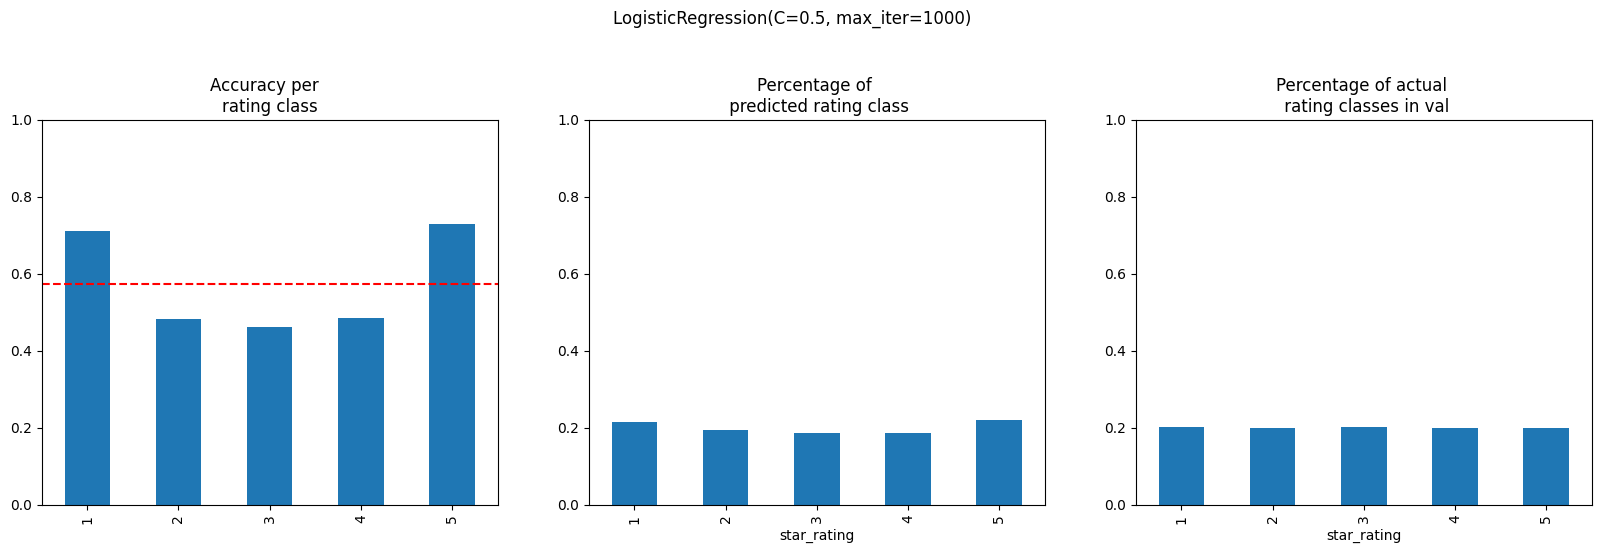

In [72]:
assess_on_val(pipeline, X_val, y_val);
confusion_matrix = pd.crosstab(y_val, pipeline.predict(X_val), rownames=['Actual class'], colnames=['Predicted class'], normalize=1)
confusion_matrix
# Start predicting
# Finished predicting
# Global accuracy: 0.5735975752585516
# cm with normalization
# Predicted class	1	2	3	4	5
# Actual class					
# 1	0.660099	0.224076	0.046585	0.014297	0.016662
# 2	0.225526	0.496649	0.222979	0.043618	0.022034
# 3	0.072632	0.221682	0.500115	0.198237	0.057995
# 4	0.024112	0.043232	0.193108	0.522077	0.242047
# 5	0.017632	0.014361	0.037214	0.221771	0.661263
# cm without normalize
# Predicted class	1	2	3	4	5
# Actual class					
# 1	20067	6085	1218	373	518
# 2	6856	13487	5830	1138	685
# 3	2208	6020	13076	5172	1803
# 4	733	1174	5049	13621	7525
# 5	536	390	973	5786	2055

In [35]:
# dir(pipeline)

In [39]:
# pipeline.get_params()

In [40]:
#dir(pipeline["tfidf"])
# dir(pipeline["vect"])

#### Strongest and weakest features in prediction

In [92]:
tok_coef = pd.DataFrame(
    {
        "token": pipeline["vect"].get_feature_names_out()
        , "coef_1": pipeline["clf"].coef_[0,:]
        , "coef_2": pipeline["clf"].coef_[1,:]
        , "coef_3": pipeline["clf"].coef_[2,:]
        , "coef_4": pipeline["clf"].coef_[3,:]
        , "coef_5": pipeline["clf"].coef_[4,:]
    }
)

tok_coef.head()

token    coef_1    coef_2    coef_3    coef_4    coef_5
0               _part  0.393836 -0.607022  0.189588  0.137374 -0.113776
1  _part ability_noun -0.002530  0.142029 -0.094377 -0.093846  0.048725
2     _part and_cconj  0.095189 -0.144520  0.169068 -0.110622 -0.009116
3     _part face_noun -0.023371 -0.053671  0.002515 -0.014157  0.088684
4     _part game_noun  0.084038 -0.001200  0.059099 -0.191279  0.049342

In [86]:
tok_coef["delta_5_to_1"] = tok_coef["coef_5"] - tok_coef["coef_1"]
tok_coef["abs_delta_5_to_1"] = np.abs(tok_coef["delta_5_to_1"]) 

num = 40

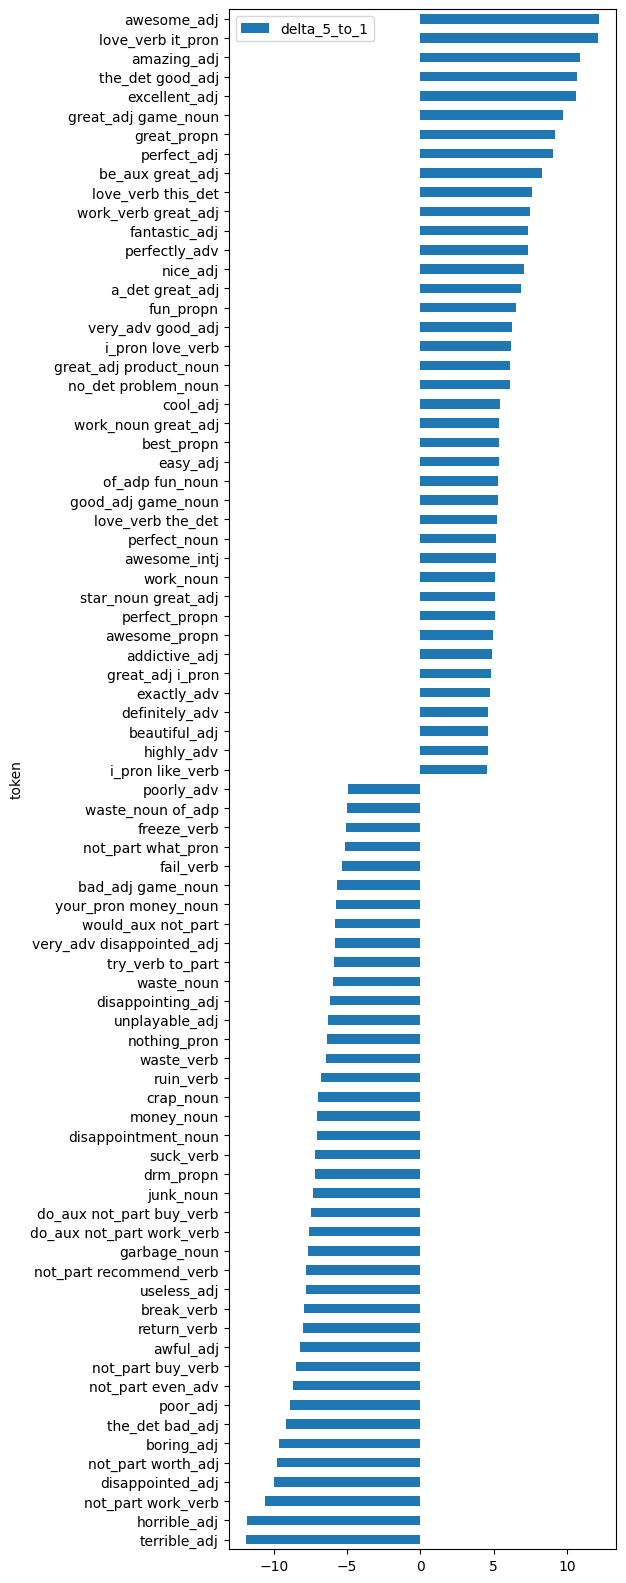

In [89]:
# strongest words for positive (rating 5) and negative (rating 1) predictions
strongest_words = pd.concat(
        [tok_coef.sort_values("delta_5_to_1").head(num), 
        tok_coef.sort_values("delta_5_to_1").tail(num)]
    )[["token", "delta_5_to_1"]].set_index("token").plot(kind="barh", figsize=(5,20))


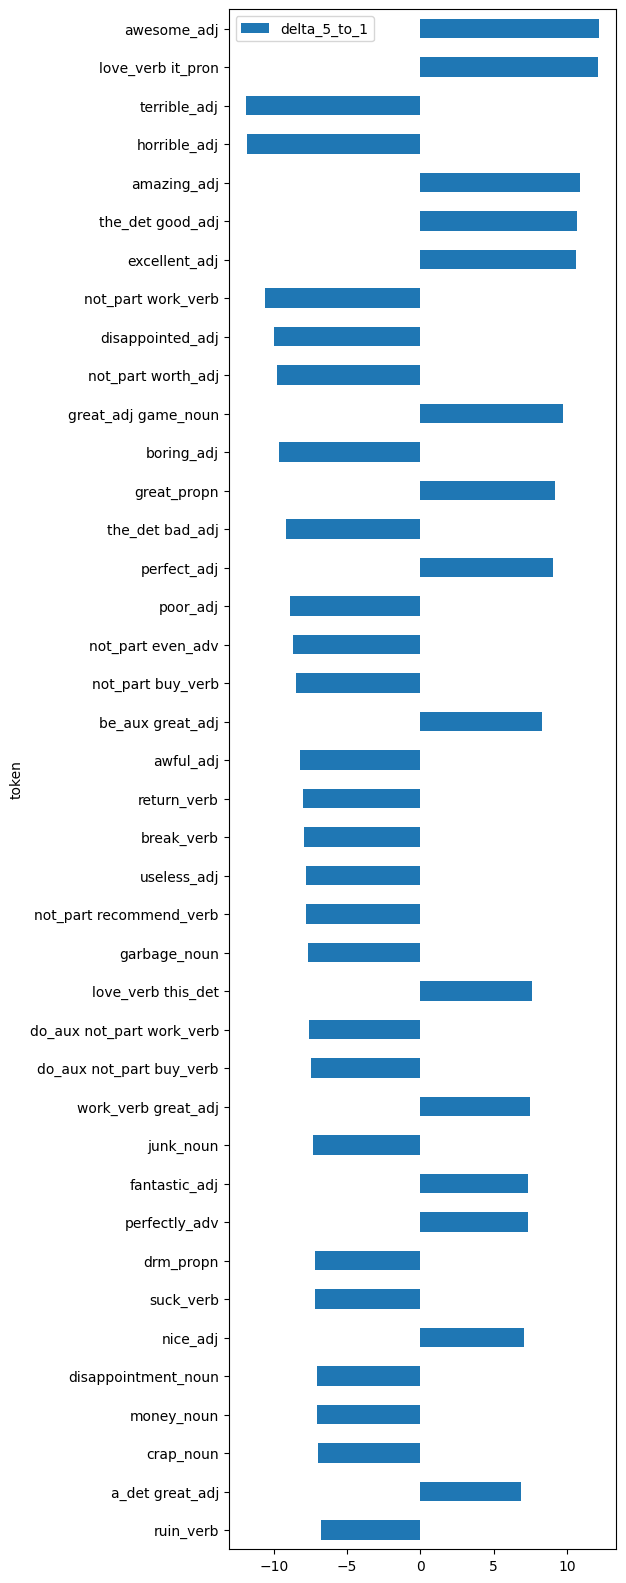

In [90]:
# strongest words (mixing positive and negative ratings)
strongest_words2 = tok_coef.sort_values("abs_delta_5_to_1").tail(num)[
    ["token", "delta_5_to_1"]].set_index("token").plot(kind="barh", figsize=(5,20))

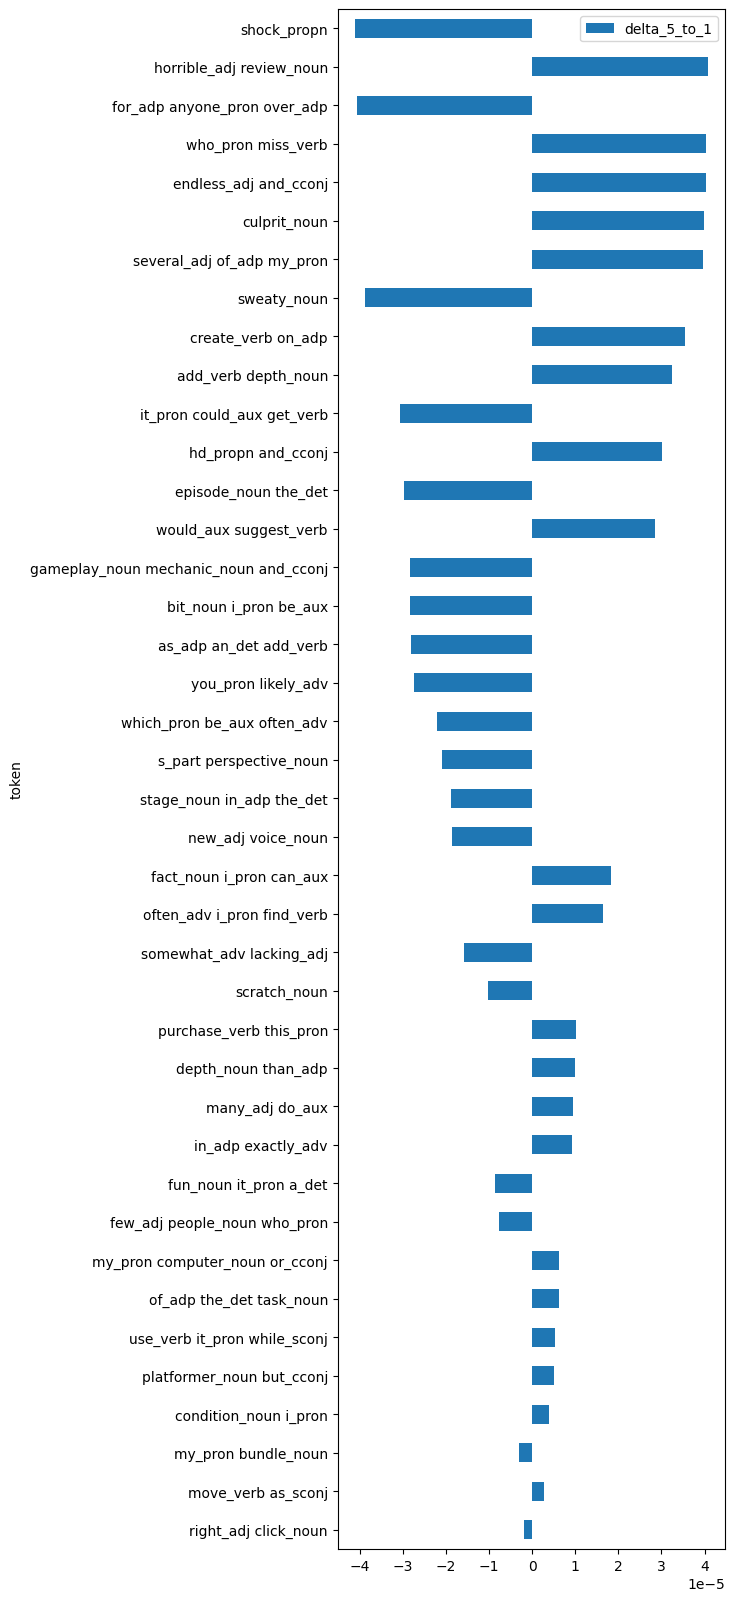

In [91]:
# weakest words (mixing positive and negative ratings)
weakest_words = tok_coef.sort_values("abs_delta_5_to_1").head(40)[
    ["token", "delta_5_to_1"]].set_index("token").plot(kind="barh", figsize=(5,20))

<Axes: >

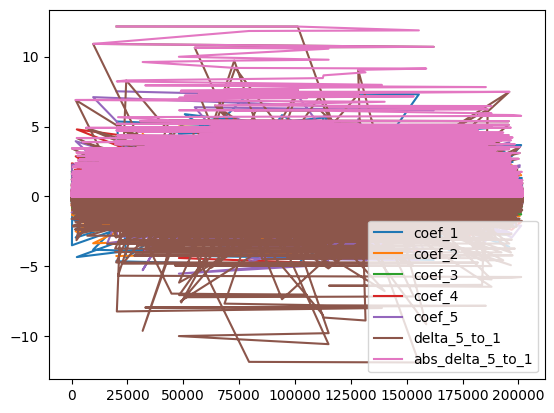

In [44]:
# does this graph make sense?
tok_coef.sort_values("abs_delta_5_to_1").plot()

In [46]:
pipeline["vect"].get_feature_names_out().shape
pipeline["clf"].coef_[0,:].shape

(201796,)

In [47]:
pipeline["tfidf"].get_feature_names_out()

array(['x0', 'x1', 'x2', ..., 'x201793', 'x201794', 'x201795'],
      dtype=object)

In [48]:
 print(len(pipeline["tfidf"].get_feature_names_out()), " / ",len(pipeline["vect"].get_feature_names_out()))

201796  /  201796


#### SHAP interpretation

In [60]:
#https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
def f(X):    
    val = pipeline.predict(X)
    return val

In [61]:
masker = shap.maskers.Text(r"\W") # this will create a basic whitespace tokenizer
explainer = shap.Explainer(f, masker)#, output_names=labels)

In [62]:
true_pred= pd.DataFrame({"true": y_val, "pred": f(X_val)})

In [84]:
true_pred["delta"] = abs(true_pred.true -true_pred.pred)

In [85]:
true_pred.value_counts("delta")

delta
0    80809
1    48323
2     8514
3     2181
4     1054
Name: count, dtype: int64

#### Explain worst predictions

In [64]:
# explain worst 7 explanation
shap_values_worst = explainer(X_val[true_pred.sort_values("delta", ascending=False).head(7).index])

In [77]:
X_val[true_pred.sort_values("delta", ascending=False).head(7).index]


array(['there_PRON nothing_PRON I_PRON could_AUX write_VERB here_ADV that_PRON would_AUX convince_VERB you_PRON there_PRON nothing_PRON I_PRON could_AUX write_VERB here_ADV that_PRON would_AUX convince_VERB you_PRON to_PART play_VERB this_DET game_NOUN if_SCONJ you_PRON do_AUX not_PART already_ADV have_VERB it_PRON but_CCONJ on_ADP the_DET small_ADJ chance_NOUN that_SCONJ you_PRON do_AUX not_PART go_VERB buy_VERB it_PRON play_VERB it_PRON spend_VERB your_PRON eat_VERB bee_NOUN and_CCONJ scale_VERB mountain_NOUN',
       "to_PART stop_VERB console_NOUN production_NOUN what_PRON ahead_ADV by_ADP troubled_ADJ officially_ADV announce_VERB it_PRON would_AUX end_VERB production_NOUN of_ADP its_PRON game_NOUN console_NOUN and_CCONJ restructure_NOUN to_PART concentrate_VERB on_ADP sell_VERB game_NOUN software_NOUN for_ADP its_PRON rival_NOUN '_PART equipment_NOUN will_AUX restructure_VERB its_PRON overseas_ADJ sale_NOUN unit_NOUN and_CCONJ affiliate_NOUN to_PART cut_VERB cost_NOUN we_PRON be_A

In [83]:
true_pred.sort_values("delta", ascending=False).head(7)

true  pred  delta
59833      5     1      4
132777     5     1      4
126702     5     1      4
43763      1     5      4
132722     1     5      4
132724     1     5      4
117707     1     5      4

In [65]:
shap.plots.text(shap_values_worst)

#### Explain best prections

In [66]:
shap_values_best = explainer(X_val[true_pred.sort_values("delta", ascending=False).tail(7).index])

In [67]:
shap.plots.text(shap_values_worst)

#### Recoding labels -- positive, neutral, negative reviews

In [93]:
def recode_labels(in_array):
        rec = [0 if x in [1,2] else (1 if x ==3 else 2) for x in in_array]
        return(np.array(rec))
y_train_rec = recode_labels(y_train)

In [97]:
tes = pd.DataFrame({"rec": y_train_rec, "orig": y_train})
tes.head(5)

rec  orig
0    0     2
1    2     4
2    2     4
3    2     5
4    2     5

In [95]:
# recode labels
def recode_labels(in_array):
        rec = [0 if x in [1,2] else (1 if x ==3 else 2) for x in in_array]
        return(np.array(rec))


lr_params = dict(C=0.5, max_iter=1000)
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.001, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
#varth_params = dict(threshold=0.00005/100)
#percth_params = dict(score_func= selpc_fun, percentile = 95)
# Supervised Pipeline

lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

pipeline = Pipeline(lr_steps)

In [96]:
pipeline.fit(X_train, recode_labels(y_train))
print("Training_Score: ", 
    pipeline.score(X_train, recode_labels(y_train)), 
    " / Val. Score: ", pipeline.score(X_val, recode_labels(y_val))
)
# Training_Score:  0.792857827322963  / Val. Score:  0.7643117240791873

Training_Score:  0.792857827322963  / Val. Score:  0.7643117240791873


Start predicting
Finished predicting
Global accuracy: 0.7643117240791873


Predicted class         0         1         2
Actual class                                 
0                0.784542  0.235304  0.055378
1                0.159877  0.553343  0.139232
2                0.055581  0.211353  0.805390

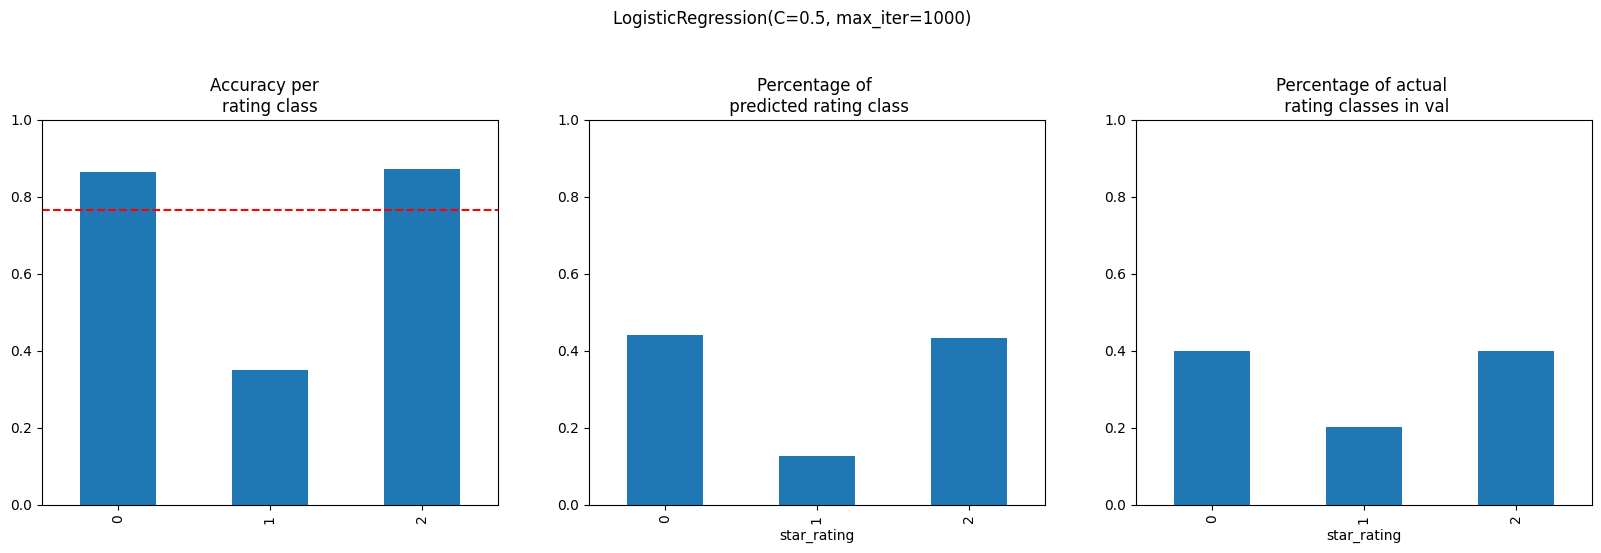

In [98]:
assess_on_val(pipeline, X_val, recode_labels(y_val));
confusion_matrix = pd.crosstab(
        recode_labels(y_val), pipeline.predict(X_val), 
        rownames=['Actual class'], colnames=['Predicted class'], normalize=1
    )

confusion_matrix
# Start predicting
# Finished predicting
# Global accuracy: 0.7643117240791873 # before with 5 class > 0.57
# Predicted class	0	1	2
# Actual class			
# 0	0.784542	0.235304	0.055378
# 1	0.159877	0.553343	0.139232
# 2	0.055581	0.211353	0.805390

In [100]:
pd.DataFrame(recode_labels(pipeline.predict(X_val))).value_counts()

0    78827
2    62054
Name: count, dtype: int64

In [99]:
pd.DataFrame(pipeline.predict(X_val)).value_counts()

0    62054
2    60999
1    17828
Name: count, dtype: int64

# Word2Vec

In [12]:
from gensim.models import word2vec
import nltk
import gensim

In [20]:
# Word2Vec is not a single algorithm but a combination of two techniques – CBOW (Continuous bag of words) and Skip-gram model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

In [17]:
%%time
# wordpunct_tokenize will split pretty much at all special symbols and treat them as separate units. word_tokenize on the other hand keeps things like 're together.
# tokenization of reviews with postagging
tokenizer = nltk.WordPunctTokenizer() # extract the tokens from string of words or sentences in the form of Alphabetic and Non-Alphabetic character

X_us_tok = [tokenizer.tokenize(review) for review in X_us]
print ("Tokenize the first review:")
print (X_us_tok[0])

Tokenize the first review:
['I_PRON', 'purchase_VERB', 'this_DET', 'remote_ADJ', 'control_NOUN', 'to_PART', 'make_VERB', 'watch_VERB', 'DVD_PROPN', "'", 's_PART', 'on_ADP', 'the_DET', 'easier_ADV', 'I_PRON', 'have_VERB', 'problem_NOUN', 'get_VERB', 'it_PRON', 'to_PART', 'work_VERB', 'consistantly_ADV', 'right_ADV', 'out_ADP', 'of_ADP', 'the_DET', 'box_NOUN', 'I_PRON', 'have_VERB', 'to_PART', 'press_VERB', 'most_ADJ', 'of_ADP', 'the_DET', 'button_NOUN', 'very_ADV', 'hard_ADV', 'to_PART', 'get_VERB', 'they_PRON', 'to_PART', 'work_VERB', 'I_PRON', 'hope_VERB', 'it_PRON', 'would_AUX', 'get_VERB', 'well_ADJ', 'but_CCONJ', 'it_PRON', 'only_ADV', 'get_VERB', 'bad_ADJ', 'I_PRON', 'be_AUX', 'now_ADV', 'back_ADV', 'to_ADP', 'use_VERB', 'the_DET', 'game_NOUN', 'controler_NOUN', 'and_CCONJ', 'throw_VERB', 'the_DET', 'remote_ADJ', 'control_NOUN', 'away_ADV', 'br_X', 'br_X', 'would_AUX', 'never_ADV', 'recommend_VERB', 'this_DET', 'product_NOUN']
CPU times: total: 25.6 s
Wall time: 27.8 s


In [18]:
%%time
# tokenization of reviews without postagging
X_wo_pos_us_tok = [tokenizer.tokenize(review) for review in X_wo_pos_us]
print ("Tokenize the first review:")
print (X_wo_pos_us_tok[0])

Tokenize the first review:
['Sony', 'Playstation', '2', 'Remote', 'purchas', 'remot', 'control', 'make', 'watch', 'dvd', 'easier', 'problem', 'get', 'consist', 'right', 'box', 'press', 'button', 'hard', 'get', 'hope', 'would', 'get', 'better', 'got', 'wors', 'back', 'use', 'game', 'control', 'threw', 'remot', 'control', 'away', 'br', 'br', 'would', 'never', 'recommend']
CPU times: total: 15.6 s
Wall time: 16.8 s


## self-trained model

In [70]:
%%time
# train w2v model
w2v_model = word2vec.Word2Vec(
                              # sentences=tokenized_texts, # the corpus iterable in the model constructor --> will automatically train the model. build_vocab and train can be saved. What's the difference of 2 training methods?
                              vector_size=200, # desired no. of features/independent variables
                              window=10, # context window size
                              min_count=2, # Ignores all words with total frequency lower than 2.     
                              workers=4, # no.of cores
                              sg = 1, # 1 for skip-gram model
                              negative = 10 # for negative sampling
)

CPU times: total: 0 ns
Wall time: 1 ms


In [71]:
# %%time
# # building vocabulary, build unique word of vocabulary
# w2v_model.build_vocab(X_us_tok, progress_per=1000)

In [72]:
%%time
# building vocabulary, build unique word of vocabulary
w2v_model.build_vocab(X_wo_pos_us_tok, progress_per=1000)

CPU times: total: 6.56 s
Wall time: 7.31 s


In [75]:
# %%time
# # actual training
# w2v_model.train(X_wo_pos_us_tok, 
#                 total_examples= w2v_model.corpus_count, 
#                 epochs=w2v_model.epochs # how many times you want to iterate the entire dataset
# )

CPU times: total: 1h 20min 13s
Wall time: 32min 40s


(132414546, 147662535)

In [21]:
# save the self-trained w2v model
# w2v_model.save(project_path+"/data/trained_model/word2vec_selftrained_wo_pos_0424.model")

In [23]:
# load the pre-trained model
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load(path+'/data/trained_model/word2vec_selftrained_wo_pos_0424.model', mmap='r')

In [31]:
# getting the training loss value
training_loss = w2v_model.get_latest_training_loss()
print(training_loss) # 0.0 does it make sense that training loss of the w2v model is 0.0?

0.0


In [26]:
# test similarity of good_ADJ / good
vector = w2v_model.wv['good']  # get numpy vector of a word
sims = w2v_model.wv.most_similar('good', topn=10)  # get other similar words
sims

[('great', 0.8249239921569824),
 ('excel', 0.7722135186195374),
 ('decent', 0.7443047165870667),
 ('nice', 0.7341094017028809),
 ('cooooool', 0.6993768811225891),
 ('realli', 0.6939755082130432),
 ('goog', 0.6937705278396606),
 ('aaaaa', 0.6924640536308289),
 ('awesom', 0.6884016394615173),
 ('verygood', 0.6793662905693054)]

In [27]:
# test similarity of like
sims = w2v_model.wv.most_similar('like', topn=10)  # get other similar words
sims

[('think', 0.7283892035484314),
 ('love', 0.7210031151771545),
 ('realli', 0.7197202444076538),
 ('want', 0.715018093585968),
 ('radically', 0.7113955616950989),
 ('stree', 0.7093276381492615),
 ('dgb', 0.7061249017715454),
 ('actual', 0.7049920558929443),
 ('thoughtit', 0.70469069480896),
 ('dthe', 0.7022296786308289)]

In [30]:
# test similarity of bad
sims = w2v_model.wv.most_similar('bad', topn=10)  # get other similar words
sims

[('graphicss', 0.6485788226127625),
 ('good', 0.6468968987464905),
 ('Shabby', 0.6336789131164551),
 ('baaaaaad', 0.6291819214820862),
 ('terribl', 0.6259354948997498),
 ('nonspecif', 0.6246826648712158),
 ('baf', 0.6220371127128601),
 ('ocirina', 0.6185489296913147),
 ('thaaaat', 0.6182568073272705),
 ('arkum', 0.6162353754043579)]

In [ ]:
# Create feature vectors
def create_features(review_tokens, model):
    num_features = model.vector_size
    features = np.zeros((len(review_tokens), num_features), dtype="float32")
    for i, tokens in enumerate(review_tokens):
        for token in tokens:
            if token in model.wv.key_to_index:
                features[i] += model.wv.get_vector(token)
    return features

In [34]:
%%time
# create features. Output of create_features is array and needs to be converted to dataframe
X_train_features = pd.DataFrame(create_features(X_train, w2v_model))
X_test_features = pd.DataFrame(create_features(X_test, w2v_model))
X_val_features = pd.DataFrame(create_features(X_val, w2v_model))

CPU times: total: 39min 47s
Wall time: 41min 42s


In [35]:
X_train_features

array([[  26.965054 ,   48.4049   ,  144.61964  , ...,  -46.29098  ,
         -71.96297  ,   14.111546 ],
       [  20.523005 ,   40.320507 ,  117.09506  , ...,  -37.11856  ,
         -52.56328  ,   13.19147  ],
       [   6.740221 ,   12.729512 ,   30.99062  , ...,  -11.981878 ,
         -15.138052 ,    3.976224 ],
       ...,
       [ 199.58815  ,  282.5427   ,  779.0265   , ..., -280.11078  ,
        -322.2039   ,   63.915577 ],
       [   7.3645554,   11.139233 ,   30.620867 , ...,  -13.024079 ,
         -13.003095 ,    4.477416 ],
       [  52.29697  ,   81.853226 ,  231.35565  , ...,  -81.491776 ,
        -100.111534 ,   23.083628 ]], dtype=float32)

In [38]:
X_train_features.to_csv(path + "/word2vec_selftrained_wo_pos_X_train_features_0424.csv", index=False)
X_test_features.to_csv(path + "/word2vec_selftrained_wo_pos_X_test_features_0424.csv", index=False)
X_val_features.to_csv(path + "/word2vec_selftrained_wo_pos_X_val_features_0424.csv", index=False)

### Plots > word similaritiy

In [ ]:
# t-SNE visualizations
def tsnescatterplot(model, word, list_names, feature_size):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, feature_size), dtype='f') 
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays) # min(n_samples, n_features)=19
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(12)

    
    plt.xlim(Y[:, 0].min()-5, Y[:, 0].max()+5)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()*1.1)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

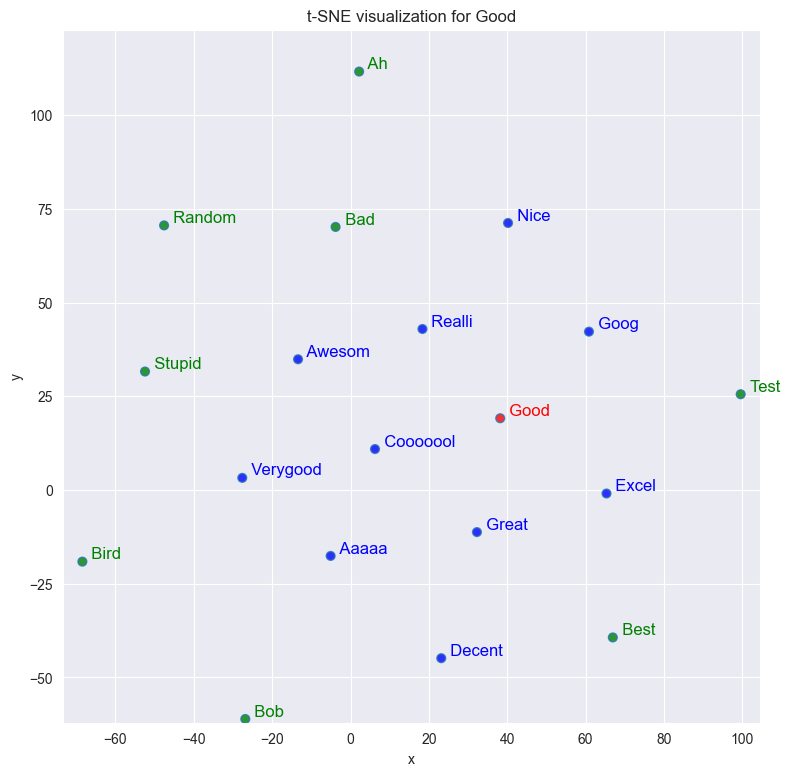

In [ ]:
# plot for self-trained model > good compared to some random words
tsnescatterplot(w2v_model, 'good', ['best', 'bird', 'ah', 'test', 'bob', 'random', 'bad', 'stupid'], 200)

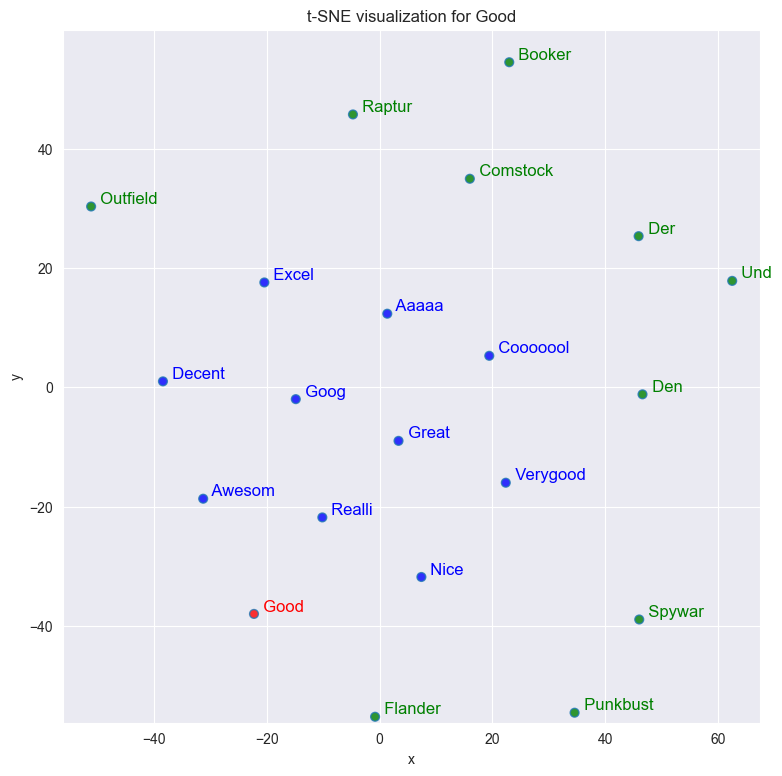

In [ ]:
# plot for self-trained model > 10 Most similar words vs. 10 Most dissimilar
tsnescatterplot(w2v_model, 'good', [i[0] for i in w2v_model.wv.most_similar(negative=["good"])], 200)

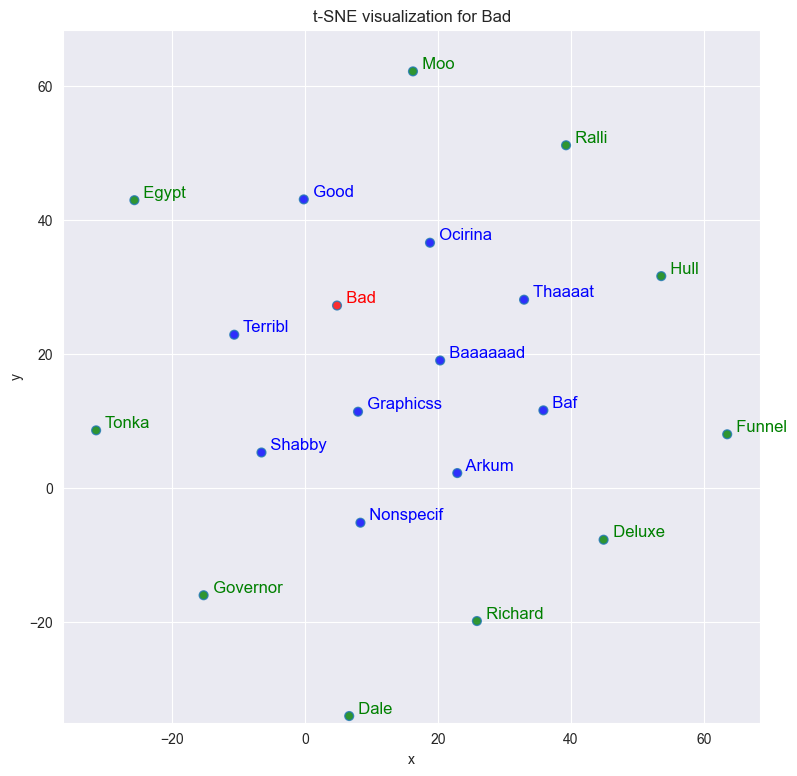

In [ ]:
tsnescatterplot(w2v_model, 'bad', [i[0] for i in w2v_model.wv.most_similar(negative=["bad"])], 200)

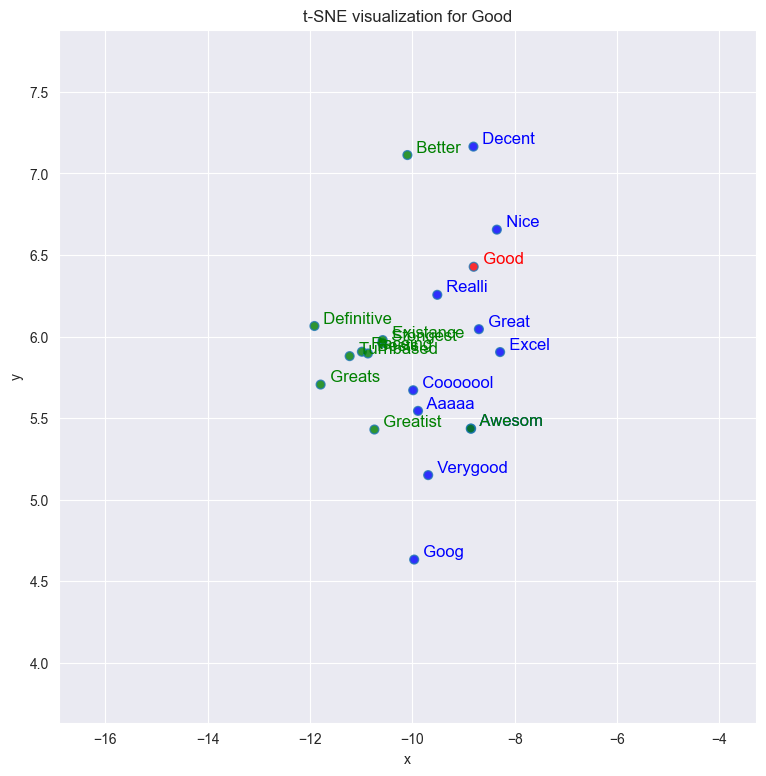

In [ ]:
# plot for self-trained model > 1-10 most similar vs 11-20 most similar
tsnescatterplot(w2v_model, "good", [t[0] for t in w2v_model.wv.most_similar(positive=["best"], topn=20)][10:], 200)

### logistic regression

In [62]:
lreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 
# default max_iter=100 is not enough --> no convergence. verbose=1 does not work for the multiclass/multilabel

In [70]:
lreg = LogisticRegression(C=0.5, max_iter=1000) 

In [71]:
lreg.fit(X_train_features, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=0.5, max_iter=1000)

In [72]:
y_pred = lreg.predict(X_test_features)


In [73]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') # https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=The%20weighted%2Daveraged%20F1%20score,the%20class%20in%20the%20dataset.
recall = recall_score(y_test, y_pred, average='weighted')

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

# Result of parameters multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1
# accuracy: 0.3608526223887907
# precision: 0.3489325866334946
# recall: 0.3608526223887907

# Result of parameters C=0.5, max_iter=1000
# accuracy: 0.3602137944251613
# precision: 0.3470515288981963
# recall: 0.3602137944251613

accuracy: 0.3602137944251613
precision: 0.3470515288981963
recall: 0.3602137944251613


## pre-trained model

Reference: 

1. https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/
2. https://thinkingneuron.com/how-to-classify-text-using-word2vec/#GloVe

using google news model > needs to be downloaded from google drive (link (cannot be opened in working laptop): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [39]:
# loading the word vectors from Google trained word2vec model
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format(path + '/data/trained_model/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [74]:
GoogleModel['Best'].shape # 300 features

(300,)

In [41]:
GoogleModel.most_similar('good', topn=10) # the similarity of "good" works worse than the self-trained model

[('great', 0.7291510105133057),
 ('bad', 0.7190051078796387),
 ('terrific', 0.6889115571975708),
 ('decent', 0.6837348341941833),
 ('nice', 0.6836092472076416),
 ('excellent', 0.644292950630188),
 ('fantastic', 0.6407778263092041),
 ('better', 0.6120728850364685),
 ('solid', 0.5806034803390503),
 ('lousy', 0.576420247554779)]

In [77]:
# Checking if a word is present in the Model Vocabulary
'Hello' in GoogleModel.key_to_index.keys()

True

In [79]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += GoogleModel[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [85]:
# prepare word2vec df for pretrained w2v model
def create_w2v_df(corpus):
    wordvec_arrays = np.zeros((len(corpus), 300)) 

    print("length of corpus: ", len(corpus))

    sum = 0
    for i in range(len(corpus)):
      try:
        wordvec_arrays[i,:] = word_vector(corpus[i], 300)
      except KeyError: # handling the case where the token is empty --> need to reset index of the original df after pre-processing
          sum=sum+1
          continue
  
    return pd.DataFrame(wordvec_arrays)

CPU times: total: 0 ns
Wall time: 0 ns


In [87]:
%%time
X_train_features_pretrained = create_w2v_df(X_train)
X_test_features_pretrained = create_w2v_df(X_test)
X_valid_features_pretrained = create_w2v_df(X_valid)

length of corpus:  281763


KeyboardInterrupt: 

In [ ]:
X_train_features_pretrained.to_csv(path + "/word2vec_pretrained_wo_pos_X_train_features_0424.csv", index=False)
X_test_features_pretrained.to_csv(path + "/word2vec_pretrained_wo_pos_X_test_features_0424.csv", index=False)
X_val_features_pretrained.to_csv(path + "/word2vec_pretrained_wo_pos_X_val_features_0424.csv", index=False)

# Parameter fine-tunung

## RandomsearchCV

In [101]:
hyperparameter_grid = {
    'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,0.5,0.75,1],
    'vect__ngram_range': [(1,1),(1, 2),(1,3),(2,3)], 
    'vect__min_df': [0,0.005,0.01,0.025, 0.05,0.1],
    'vect__max_df' : [0.3, 0.35,0.5,0.75,0.9],    
}

random_cv = RandomizedSearchCV(estimator=pipeline,
            param_distributions=hyperparameter_grid,
            cv=4, 
            n_iter=15,
            scoring = 'accuracy', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            n_jobs = -1,
            verbose = 1, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits



3 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\linear_model\_logistic.py",

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(max_df=0.35,
                                                              min_df=0.001,
                                                              ngram_range=(1,
                                                                           3))),
                                             ('tfidf', TfidfTransformer()),
                                             ('clf',
                                              LogisticRegression(C=0.5,
                                                                 max_iter=1000))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,
                                                   0.5, 0.75, 1],
                                        'vect__max_df': [0.3, 0.35, 0.5, 0.75,
                                                         0.9],
                                        'vect__min_df': [0, 0.005, 0.01, 0.025,
                                                         0.05, 0.1],
                                        'vect__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3)]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [ ]:
# result of RandomSearchCV for LR
# RandomizedSearchCV(cv=4,
#                    estimator=Pipeline(steps=[('vect',
#                                               CountVectorizer(max_df=0.35,
#                                                               min_df=0.001,
#                                                               ngram_range=(1,
#                                                                            3))),
#                                              ('tfidf', TfidfTransformer()),
#                                              ('clf',
#                                               LogisticRegression(C=0.5,
#                                                                  max_iter=1000))]),
#                    n_iter=15, n_jobs=-1,
#                    param_distributions={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,
#                                                    0.5, 0.75, 1],
#                                         'vect__max_df': [0.3, 0.35, 0.5, 0.75,
#                                                          0.9],
#                                         'vect__min_df': [0, 0.005, 0.01, 0.025,
#                                                          0.05, 0.1],
#                                         'vect__ngram_range': [(1, 1), (1, 2),
#                                                               (1, 3), (2, 3)]},
#                    random_state=42, return_train_score=True, scoring='accuracy',
#                    verbose=1)

In [102]:
best_pipe = random_cv.best_estimator_
best_pipe

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.9, min_df=0.005, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=0.3, max_iter=1000))])

In [103]:
best_pipe.score(X_val, y_val)

0.55593728039977

Start predicting
Finished predicting
Global accuracy: 0.55593728039977


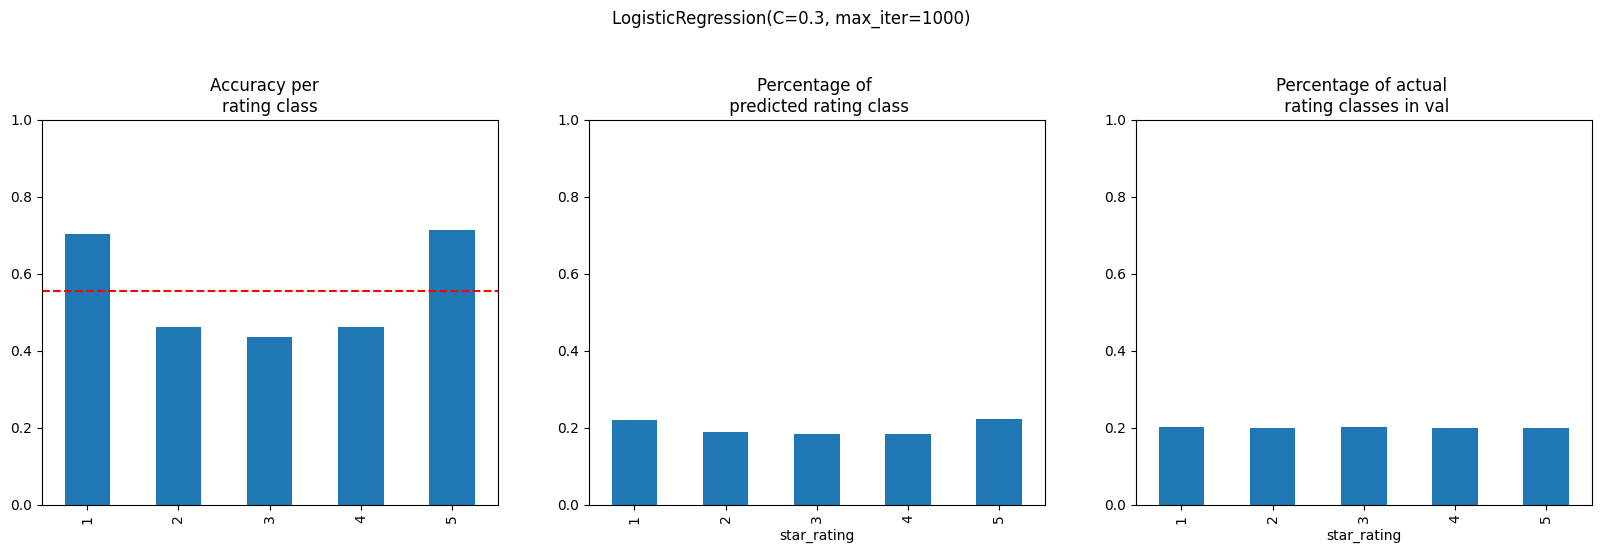

In [104]:
assess_on_val(best_pipe, X_val, y_val);

## Gridsearch

In [105]:
hyperparameter_grid = {
    'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,0.5,0.75,1],
    #'vect__ngram_range': [(1,1),(1, 2),(1,3),(2,3)], 
    'vect__min_df': [0.0001],
    'vect__max_df' : [0.075, 0.1, 0.125],        
}
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.0001, max_df=0.35-0.25)

grid_cv = GridSearchCV(estimator=pipeline,
            param_grid=hyperparameter_grid,
            cv=4,             
            scoring = 'accuracy', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            n_jobs = -1,
            verbose = 1, 
            return_train_score = True)

grid_cv.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_df=0.35,
                                                        min_df=0.001,
                                                        ngram_range=(1, 3))),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        LogisticRegression(C=0.5,
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3, 0.5, 0.75, 1],
                         'vect__max_df': [0.075, 0.1, 0.125],
                         'vect__min_df': [0.0001]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
# Result of GridSearchCV for LR
# GridSearchCV
# GridSearchCV(cv=4,
#              estimator=Pipeline(steps=[('vect',
#                                         CountVectorizer(max_df=0.35,
#                                                         min_df=0.001,
#                                                         ngram_range=(1, 3))),
#                                        ('tfidf', TfidfTransformer()),
#                                        ('clf',
#                                         LogisticRegression(C=0.5,
#                                                            max_iter=1000))]),
#              n_jobs=-1,
#              param_grid={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3, 0.5, 0.75, 1],
#                          'vect__max_df': [0.075, 0.1, 0.125],
#                          'vect__min_df': [0.0001]},
#              return_train_score=True, scoring='accuracy', verbose=1)

In [106]:
best_pipe = grid_cv.best_estimator_
best_pipe

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.1, min_df=0.0001,
                                 ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=0.5, max_iter=1000))])

In [107]:
best_pipe.score(X_val, y_val)

0.5735975752585516

Start predicting
Finished predicting
Global accuracy: 0.5735975752585516


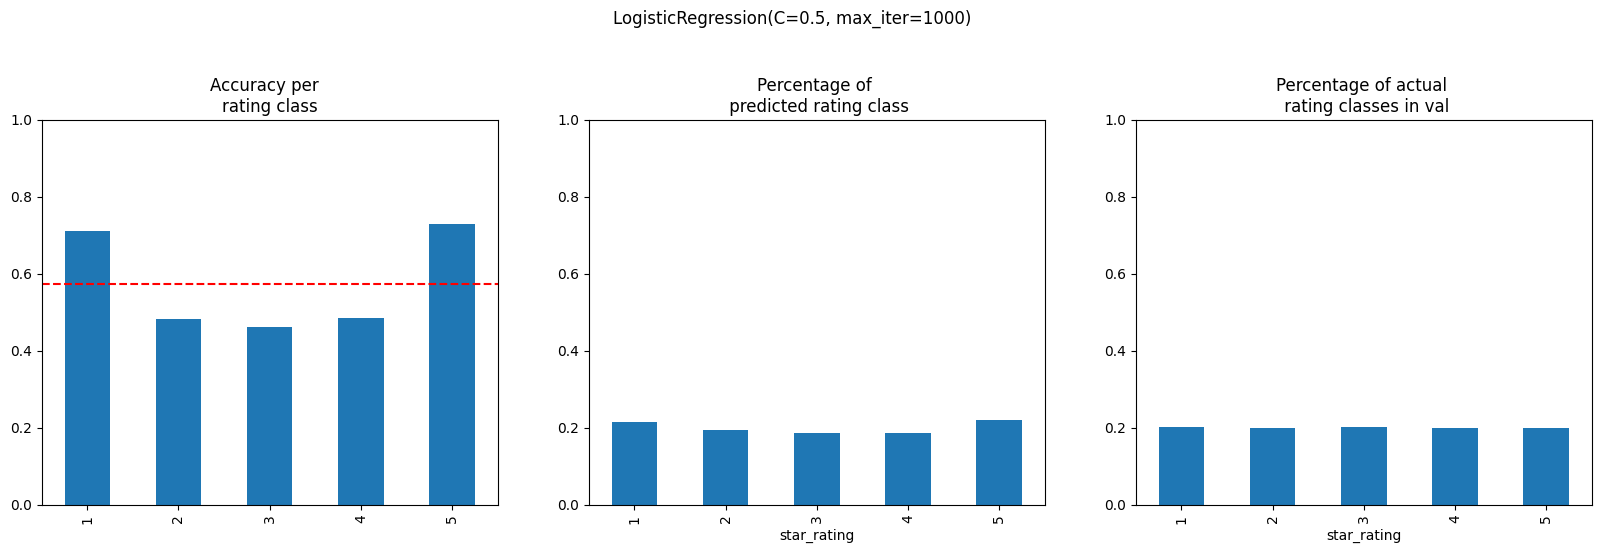

In [108]:
assess_on_val(best_pipe, X_val, y_val);

In [ ]:
import optuna 
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    """return the f1-score"""

    # search space
    n_estimators =  trial.suggest_int('n_estimators', low=100, high=200, step=50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=4, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=1, high=5, step=1)
    max_depth = trial.suggest_int('max_depth', low=5, high=7, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    # random forest classifier object
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                                  criterion=criterion,
                                                  min_samples_split=min_samples_split,
                                                  min_samples_leaf=min_samples_leaf,
                                                  max_depth=max_depth,
                                                  max_features=max_features,
                                                  random_state=42)
    score =  cross_val_score(estimator=rfc, 
                             X=X_train, 
                             y=y_train, 
                             scoring='f1_micro',
                             cv=5,
                             n_jobs=-1).mean()
    
    return score

# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, n_trials=100)
time_bayesian = time.time() - time_start

# store result in a data frame 
values_bayesian = [100, study.best_trial.number, study.best_trial.value, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

In [ ]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 19, 2) # suggest an integer from 1 to with step 2
    knn_metric=trial.suggest_categorical("knn_metric", ['euclidean', 'manhattan', 'minkowski'])
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, metric=knn_metric, weights=knn_weights)

    # SW
    lr_params = dict(C=0.5, max_iter=1000)
    vectorizer_params = dict(ngram_range=(1, 3), min_df=0.00, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
    tfidf_params = dict(norm='l2')
    varth_params = dict(threshold=0.00005/100)
    percth_params = dict(score_func= selpc_fun, percentile = 95)
    # Supervised Pipeline




    lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
            ("tfidf", TfidfTransformer(**tfidf_params)),
            #("percth", SelectPercentile(**percth_params)),
            #("varth", VarianceThreshold(**varth_params)),
            ("clf", LogisticRegression(**lr_params))]

    pipeline = Pipeline(lr_steps)

    #SW
    
    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X_train, y_train, scoring='f1')
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline

## Results after parameter finetuning

In [ ]:
lr_params = dict(C=0.5, max_iter=1000)
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.001, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
word2vec_params = dict(min_count=1, window = 5)
#percth_params = dict(score_func= selpc_fun, percentile = 95)
# Supervised Pipeline

lrw2v_steps = [ ("vect", W2VTransformer(**word2vec_params)),
        #("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

pipeline = Pipeline(lrw2v_steps)

pipeline.fit(X_train, y_train)

KeyError: "word 'got game christma gift much anticip great workout huge ufc fan workout time natur thought would great option unfortun think far mani break move far slow like hard break sweat realli friend let play kinda thing ask fun challeng workout slightest' not in vocabulary"

In [95]:
pd.DataFrame(pipeline.get_params().keys())

0
0                   memory
1                    steps
2                  verbose
3                     vect
4                    tfidf
5                      clf
6           vect__analyzer
7             vect__binary
8       vect__decode_error
9              vect__dtype
10          vect__encoding
11             vect__input
12         vect__lowercase
13            vect__max_df
14      vect__max_features
15            vect__min_df
16       vect__ngram_range
17      vect__preprocessor
18        vect__stop_words
19     vect__strip_accents
20     vect__token_pattern
21         vect__tokenizer
22        vect__vocabulary
23             tfidf__norm
24       tfidf__smooth_idf
25     tfidf__sublinear_tf
26          tfidf__use_idf
27                  clf__C
28       clf__class_weight
29               clf__dual
30      clf__fit_intercept
31  clf__intercept_scaling
32           clf__l1_ratio
33           clf__max_iter
34        clf__multi_class
35             clf__n_jobs
36            clf__penalty
37       clf__random_state
38             clf__solver
39                clf__tol
40            clf__verbose
41         clf__warm_start

In [71]:
pd.DataFrame.from_dict(lr_pipeline.steps[0][1].vocabulary_, orient="index").reset_index().sort_values(by=0)

index     0
2207       aa     0
1219      aaa     1
343   abandon     2
1635     abil     3
44        abl     4
...       ...   ...
2095      zip  3411
770     zombi  3412
2235     zone  3413
2326     zoom  3414
2808    zumba  3415

[3416 rows x 2 columns]

In [99]:
dict(zip(feature_names.ravel() , X_train_vectorized.mean(axis=1))) 
#stopwrods: xbox, nintendo, game, amazon, christma, gamecub, im, mario, around, basketbal

{'aa': matrix([[0.00034342]]),
 'aaa': matrix([[0.00059032]]),
 'ab': matrix([[0.00056063]]),
 'abacus': matrix([[0.00032889]]),
 'abandon': matrix([[0.00041731]]),
 'abba': matrix([[0.00022538]]),
 'abc': matrix([[0.00030099]]),
 'abd': matrix([[0.0004535]]),
 'abe': matrix([[0.00020932]]),
 'abil': matrix([[0.00026331]]),
 'abilit': matrix([[0.00029385]]),
 'abit': matrix([[0.00039747]]),
 'abl': matrix([[0.00049444]]),
 'abnorm': matrix([[0.00059856]]),
 'abomin': matrix([[0.00100907]]),
 'abort': matrix([[0.00063437]]),
 'abound': matrix([[0.00019273]]),
 'abras': matrix([[0.00037401]]),
 'abroad': matrix([[0.0004026]]),
 'abrupt': matrix([[0.00032712]]),
 'absenc': matrix([[0.00089944]]),
 'absent': matrix([[0.00090666]]),
 'absolut': matrix([[0.00101455]]),
 'absolutley': matrix([[0.00020835]]),
 'absorb': matrix([[0.00046401]]),
 'abstract': matrix([[0.00028085]]),
 'absurd': matrix([[0.00121324]]),
 'abt': matrix([[0.00052331]]),
 'abund': matrix([[0.00038551]]),
 'abus': matri

# Classification

In [46]:
clf_mnNB = MultinomialNB().fit(X_train_vectorized, y_train)
clf_knn = KNeighborsClassifier(n_neighbors=40).fit(X_train_vectorized, y_train)
clf_lr = LogisticRegression(max_iter=1000).fit(X_train_vectorized, y_train)
clf_lr_L2_05 = LogisticRegression( C=0.5,max_iter=1000).fit(X_train_vectorized, y_train)
clf_lr_L1_05 = LogisticRegression(penalty="l1", C=0.25,max_iter=1000, solver= "saga").fit(X_train_vectorized, y_train)
clf_xgb = xgb.XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5,
              max_delta_step=0, max_depth=20, min_child_weight=1,# missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)



# Appendix

In [45]:
# Assessement of results
# Add vine flag as feature!

In [35]:





#metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc])

Start predicting
Finished predicting
Global accuracy: 0.4617830777967064


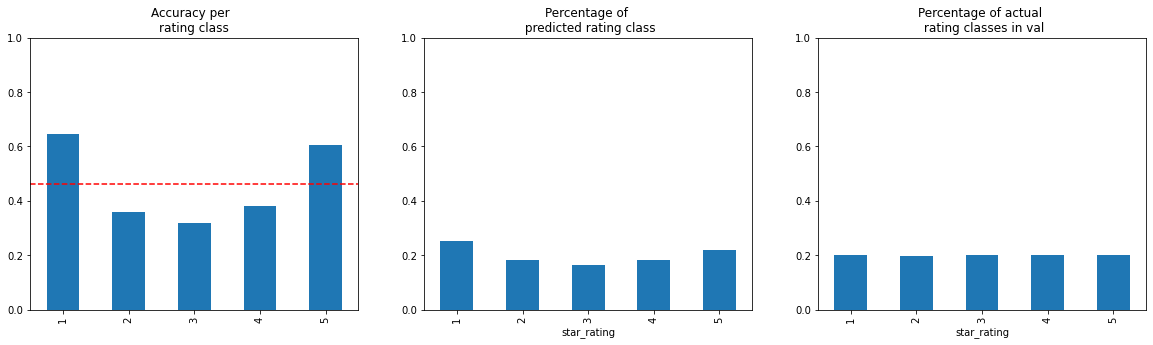

In [47]:

assess_on_val(clf_mnNB, X_val_vectorized, y_val);



Start predicting
Finished predicting
Global accuracy: 0.49646507666098805


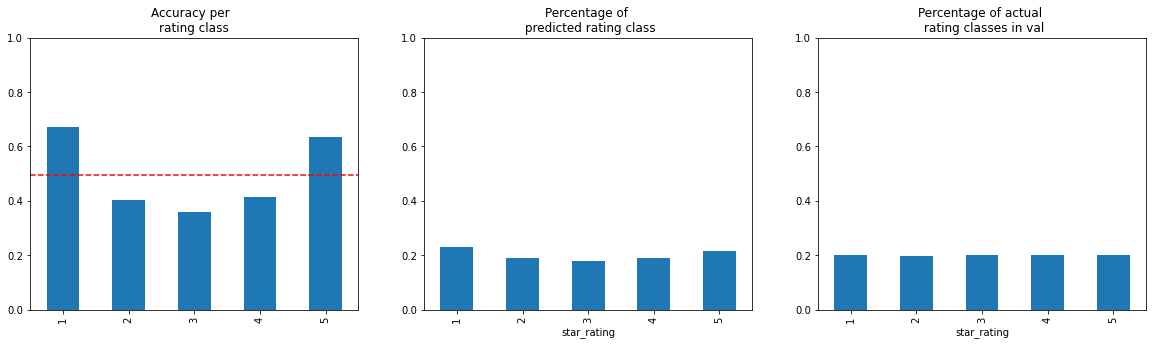

In [36]:
# New sample
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

In [46]:
clf_lr_L2_05.score(X_val_vectorized, y_val)

0.49646507666098805

Start predicting
Finished predicting
Global accuracy: 0.5043441226575809


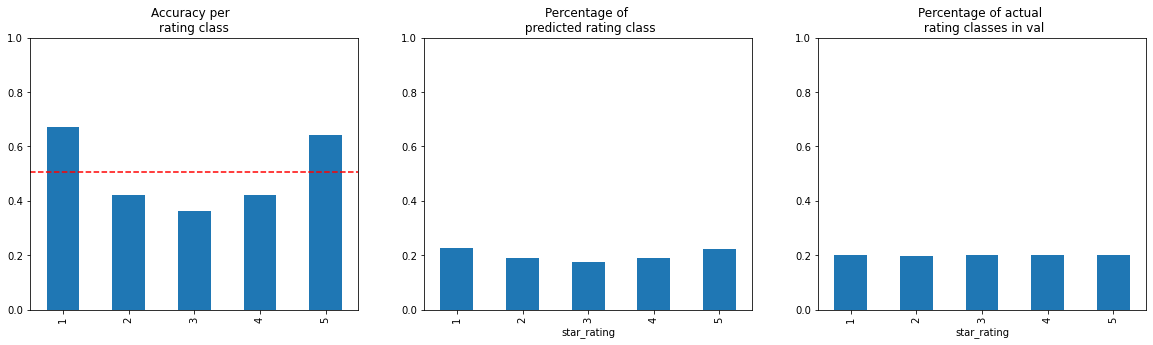

In [106]:
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

Start predicting
Finished predicting
Global accuracy: 0.49622373651334467


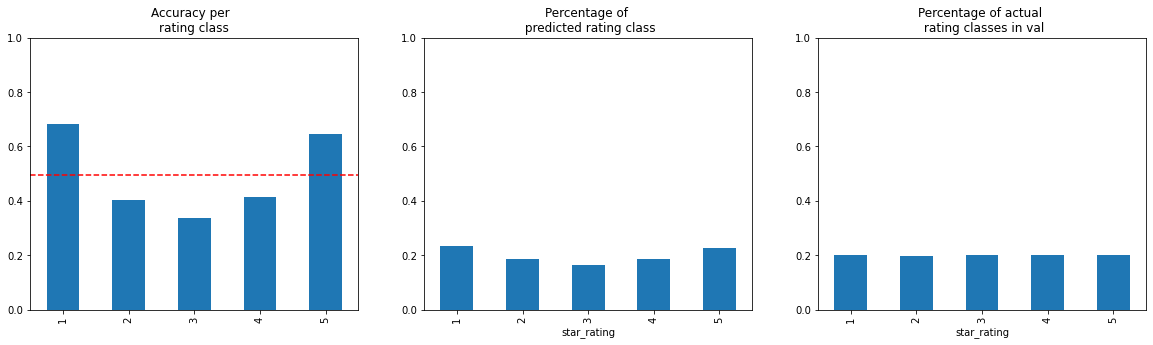

In [105]:
assess_on_val(clf_lr_L1_05, X_val_vectorized, y_val);

In [95]:
#Analyse words predicting class 0
coefs = pd.DataFrame.from_dict({"coef": clf_lr_L2_05.coef_[0,:], "feature": feature_names.ravel()}, orient="index")
coefs = coefs.transpose()
coefs["abs_coef"]=np.abs(coefs.coef)
coefs.sort_values(by="abs_coef", ascending=False).head(40)

coef     feature  abs_coef
2663  -6.34947       great   6.34947
6921  6.003601       worst  6.003601
6764  5.691694        wast  5.691694
6136  5.129915     terribl  5.129915
3605 -4.973701        love  4.973701
2931  4.359777     horribl  4.359777
5092   4.23451      return   4.23451
1609  4.134234  disappoint  4.134234
4424 -4.101356     perfect  4.101356
2479  4.002121      garbag  4.002121
540  -3.994098        best  3.994098
4578  3.877165        poor  3.877165
2418 -3.841276         fun  3.841276
392  -3.736629      awesom  3.736629
1772  3.723408         drm  3.723408
2598 -3.643766        good  3.643766
3904  3.561819       money  3.561819
4079 -3.549802        nice  3.549802
3312  3.534719        junk  3.534719
2015  3.525487        even  3.525487
384   3.475898          aw  3.475898
4289 -3.378695      overal  3.378695
2041 -3.216886       excel  3.216886
578  -3.171486         bit  3.171486
6194 -3.141913      though  3.141913
383   3.029937       avoid  3.029937
1831   2.91977          ea   2.91977
6352   2.90989       trash   2.90989
179  -2.899537        amaz  2.899537
6586  2.852078     useless  2.852078
6920  2.834552        wors  2.834552
3552 -2.833531       littl  2.833531
1300  2.808448        crap  2.808448
5959   2.79621        suck   2.79621
4958  2.787174      refund  2.787174
65   -2.762473      addict  2.762473
2141 -2.699301     fantast  2.699301
1154 -2.675159   complaint  2.675159
3038   2.66813      imposs   2.66813
1951 -2.657773       enjoy  2.657773

coef  feature
1069 -6.373212    great
1416 -5.001928     love
1748 -4.128307  perfect
221    -4.0107     best
990  -3.869566      fun
...        ...      ...
2014  4.254924   return
1172  4.397509  horribl
2430   5.17903  terribl
2661  5.757634     wast
2726   6.07725    worst

[2779 rows x 2 columns]

Start predicting
Finished predicting
Global accuracy: 0.5320414537194775


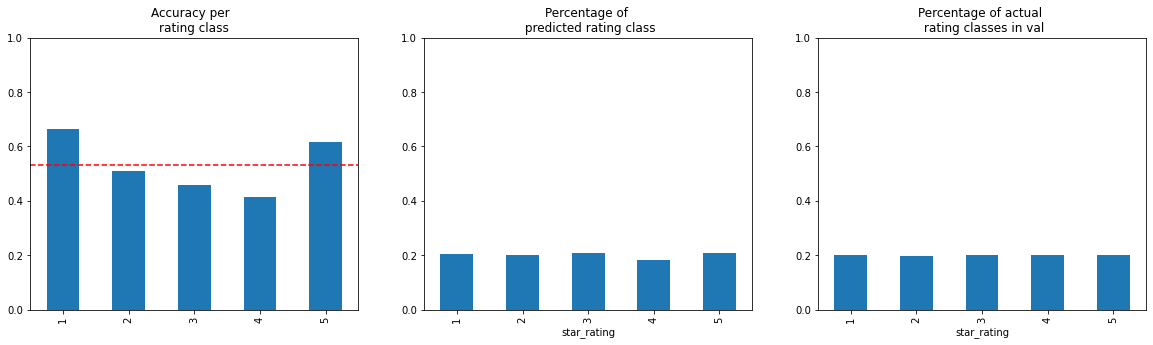

In [109]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
# 10000 features (/10 for variance threshold)

Start predicting
Finished predicting
Global accuracy: 0.5330777967064169


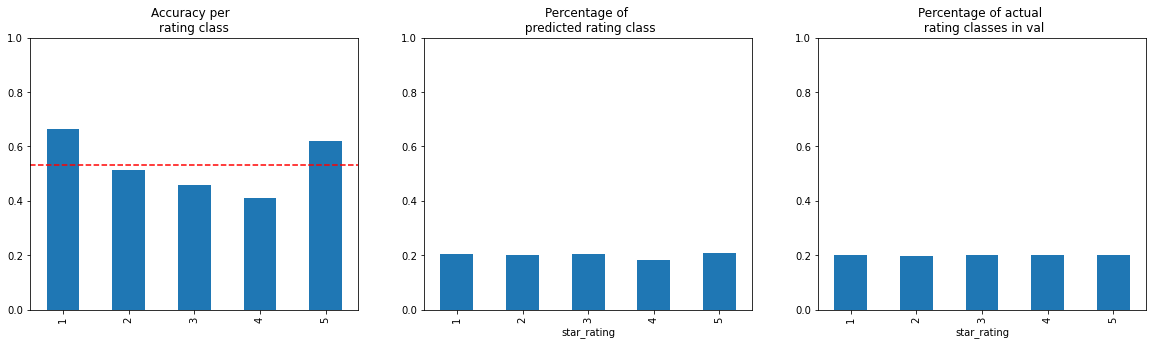

In [114]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#/2 => 4000 features

Start predicting
Finished predicting
Global accuracy: 0.5342703009653605


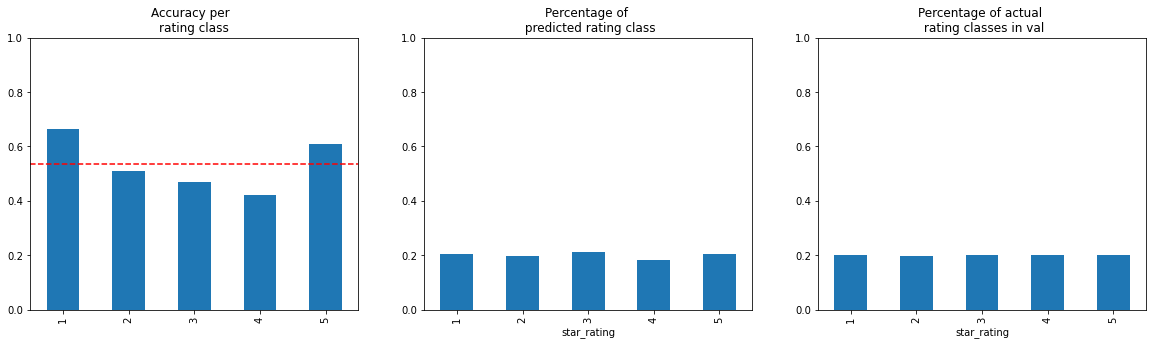

In [121]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#1 

In [46]:
import joblib
joblib.dump(clf_knn, "knn_model_dump.sav")

['knn_model_dump.sav']

In [47]:
os.getcwd()

'D:\\sep22_10_supply_chain\\data'